# Make ReadMe Plots

Used to make plots in readme files <br> Diego Alvarez <br> diego.alvarez@colorado.edu

In [1]:
!pip install july


[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import july

## Packages

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Path Management

In [4]:
parent_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_path = os.path.join(parent_path, "data")
price_sample_path = os.path.join(data_path, "prices_sample.parquet")

## Read in data

In [5]:
df_prices = pd.read_parquet(
    path = price_sample_path,
    engine = "pyarrow")

## Make Notation Markdown

In [6]:
def create_notation_example(df_raw: pd.DataFrame):

    specific_contracts = ["NYC1", "Chicago1"]
    print(df_raw.query(
        "contract_name == @specific_contracts")
        [["nyc_time", "contract"]].
        groupby("contract").
        head(1).
        sort_values("nyc_time").
        head(6).
        rename(columns = {"nyc_time": "Start Date (NYC Localized)"}).
        set_index("Start Date (NYC Localized)").
        to_markdown())
    
create_notation_example(df_prices)

| Start Date (NYC Localized)   | contract    |
|:-----------------------------|:------------|
| 2022-01-01 00:00:00          | NYC1_37     |
| 2022-01-01 01:00:00          | Chicago1_37 |
| 2022-01-17 00:00:00          | NYC1_38     |
| 2022-01-17 01:00:00          | Chicago1_38 |
| 2022-04-15 00:00:00          | NYC1_39     |
| 2022-04-15 01:00:00          | Chicago1_39 |


## Roll Example

In [7]:
df_nyc = (df_prices.query(
    "contract_name == 'NYC1'").
    assign(year = lambda x: x.nyc_time.dt.year).
    query("year == year.max()").
    set_index("nyc_time")
    [["close_price", "contract"]].
    reset_index().
    sort_index())

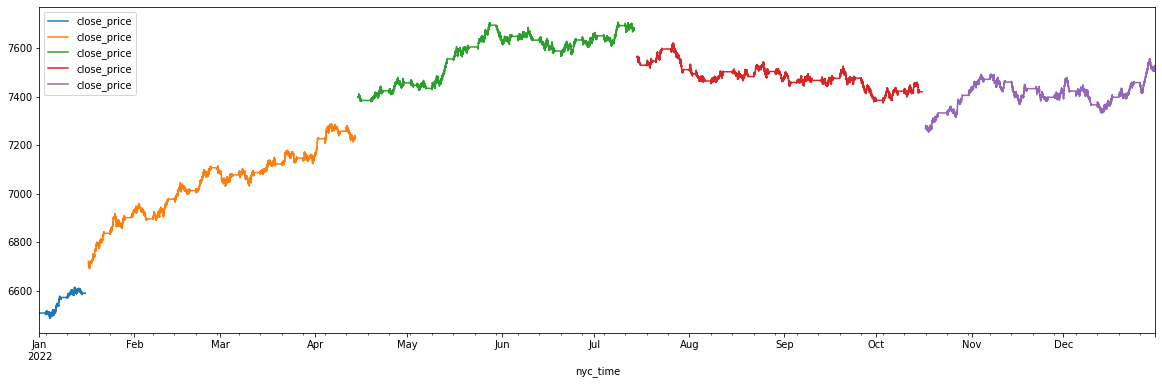

In [8]:
contracts = df_nyc.contract.drop_duplicates().to_list()
fig, axes = plt.subplots(figsize = (20,6))

for i, contract in enumerate(contracts):

    (df_nyc.query(
        "contract == @contract").
        drop(columns = ["contract"]).
        assign(date = lambda x: pd.to_datetime(x.nyc_time.dt.date)).
        query("date != date.max()").
        drop(columns = ["date"]).
        set_index("nyc_time").
        plot(
            ax = axes))

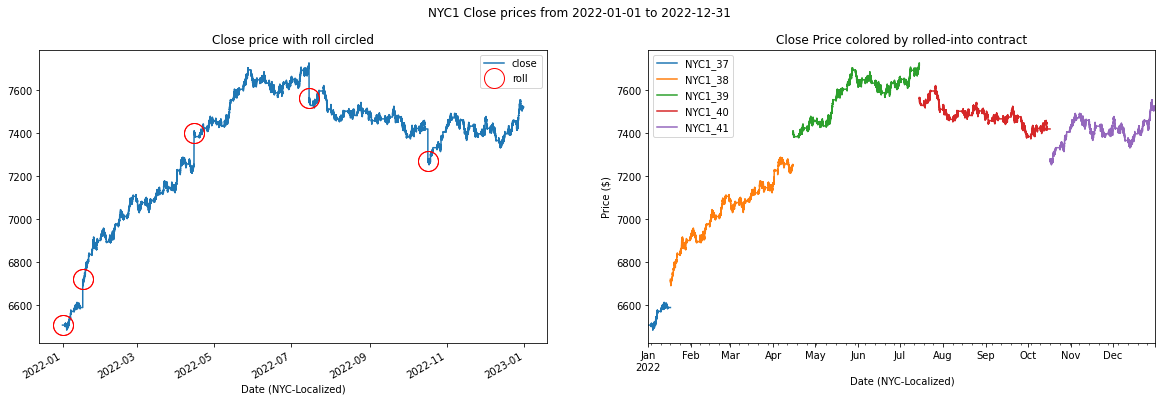

In [9]:
def plot_sample_roll(df_raw: pd.DataFrame):

    # extracting data
    max_year = df_raw.nyc_time.max().year
    specific_contract = "NYC1"
    
    df_tmp = (df_raw.query(
        "contract_name == @specific_contract").
        assign(year = lambda x: x.nyc_time.dt.year).
        query("year == @max_year").
        set_index("nyc_time")
        [["close_price", "contract"]])

    # getting mean prices for circle
    roll_dates_first = (df_tmp.groupby(
        "contract").
        head(1).
        reset_index().
        rename(columns = {"close_price": "p1"}))

    roll_dates_last = (df_tmp.groupby(
        "contract").
        head(2).
        reset_index().
        rename(columns = {"close_price": "p2"}))

    roll_mid = (roll_dates_first.merge(
        right = roll_dates_last.drop(columns = ["nyc_time"]),
        how = "inner",
        on = ["contract"]).
        set_index(["nyc_time", "contract"]).
        mean(axis = 1).
        reset_index().
        drop(columns = ["contract"]).
        rename(columns = {0: "mid"}))

    # plotting
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))
    
    (df_tmp.drop(
        columns = ["contract"]).
        rename(columns = {"close_price": "close"}).
        plot(
            ax = axes[0],
            legend = False,
            xlabel = "Date (NYC-Localized)",
            title = "Close price with roll circled"))

    axes[0].plot_date(
        x = roll_mid.nyc_time, 
        y = roll_mid.mid,
        fmt = "or",
        fillstyle = "none",
        ms = 20,
        label = "roll")

    axes[0].legend()

    contracts = df_tmp.contract.drop_duplicates().to_list()
    for contract in contracts:

        (df_tmp.query(
            "contract == @contract").
            rename(columns = {"close_price": contract}).
            drop(columns = ["contract"]).
            plot(
                ax = axes[1],
                ylabel = "Price ($)",
                xlabel = "Date (NYC-Localized)",
                title = "Close Price colored by rolled-into contract"))

    fig.suptitle("{} Close prices from {} to {}".format(
        specific_contract,
        df_tmp.index.min().date(),
        df_tmp.index.max().date()))
    
plot_sample_roll(df_prices)

## Calendar heatmap

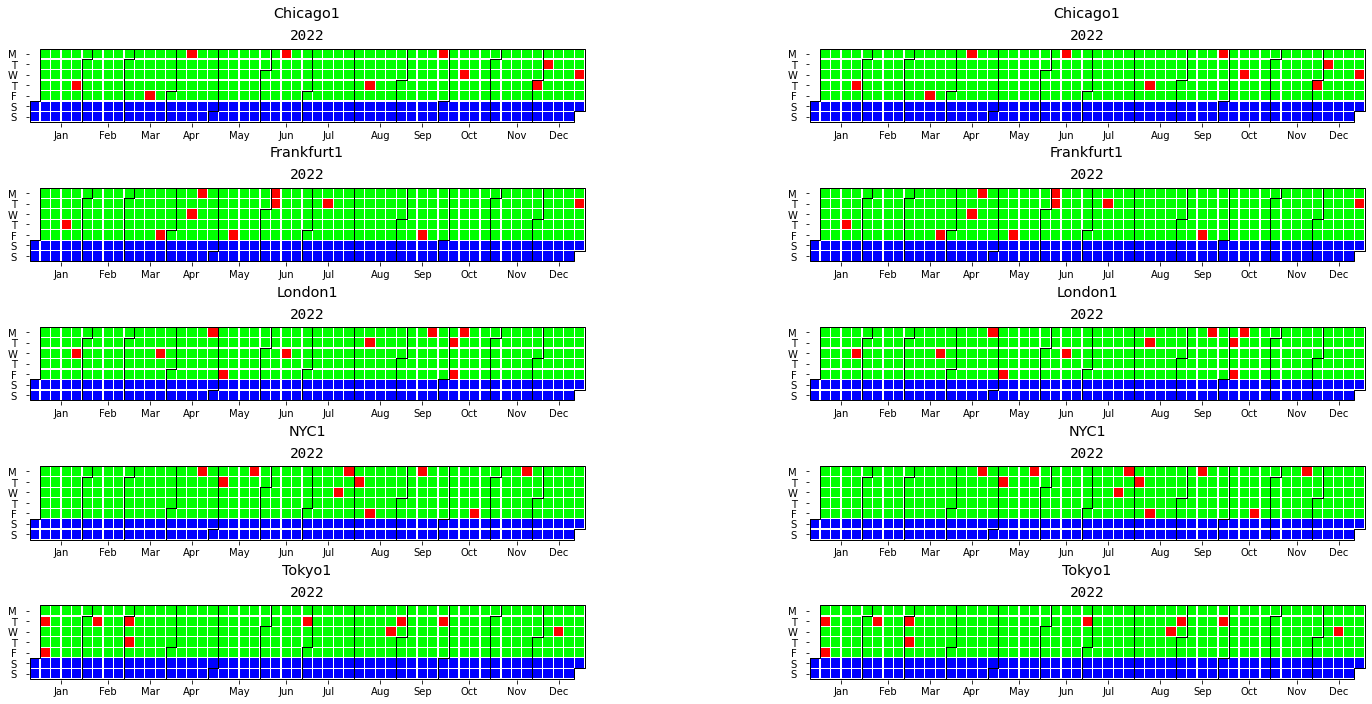

In [10]:
def make_calendar(df_price: pd.DataFrame):

    df_year = (df_prices.assign(
        date = lambda x: pd.to_datetime(x.local_time.dt.strftime("%Y-%m-%d")))
        [["contract_name", "market_day", "date"]].
        drop_duplicates().
        assign(year = lambda x: x.date.dt.year))

    max_year = max(df_year.year.drop_duplicates().to_list())
    prev_year = max_year

    df_color = (pd.DataFrame({
        "market_day": ["closed", "holiday", "open"],
        "color": [-100, 0, 100]}))

    df_colormap = (df_year.merge(
        right = df_color, how = "inner", on = ["market_day"])
        [["year", "date", "color", "contract_name"]])

    contracts = df_colormap.contract_name.drop_duplicates().to_list()
    fig, axes = plt.subplots(nrows = len(contracts), ncols = 2, figsize = (22, 10))
    for i, contract in enumerate(contracts):

        df_colormap_max_year = df_colormap.query("contract_name == @contract & year == @max_year")
        df_colormap_prev_year = df_colormap.query("contract_name == @contract & year == @prev_year")
            
        july.heatmap(
            dates = df_colormap_max_year.date,
            data = df_colormap_max_year.color,
            cmap = "brg",
            month_grid = True,
            title = contract,
            ax = axes[i, 0])
    
        july.heatmap(
            dates = df_colormap_prev_year.date,
            data = df_colormap_prev_year.color,
            cmap = "brg",
            month_grid = True,
            title = contract,
            ax = axes[i, 1])

    plt.tight_layout(pad = 2)
    
make_calendar(df_prices)